### Accessing AlphaBuilding HVAC time series from the public S3 bucket

Instead of downloading the full 1.2 TB AlphaBuilding HDF5 file to local disk,  
I access the dataset directly from the public OEDI S3 bucket using `s3fs` and `h5py`.

The HDF5 file is stored at

`A_Synthetic_Building_Operation_Dataset.h5`
inside the bucket  
`s3://oedi-data-lake/building_synthetic_dataset/`.

In this project I only need one representative building / climate configuration,
so I load a single HVAC electricity time series from

`/3. Data/3.2. Timeseries/5A/Standard/1982/run_3/ElectricityHVAC`.

The code cell below

- opens the HDF5 file in read-only mode via `s3fs.S3FileSystem(anon=True)` and `h5py.File`,  
- extracts the 10-minute HVAC electricity demand stored in the `ElectricityHVAC` group,  
- aggregates the 10-minute data to hourly average power (kW), and  
- returns a `pandas.DataFrame` with a DateTimeIndex from `1982-01-01` at 1-hour resolution.

This hourly HVAC load series is then used as the target variable \(y_t\) in the forecasting models (persistence, linear regression, random forest, LSTM, and the Neural ODE comparator), consistent with the setup described in the progress report.

> 中文说明：这里我没有把 1.2TB 的 HDF5 整体下载下来，而是用 `s3fs + h5py` 直接从公共 S3 桶里流式读取其中一个 building/climate 的 HVAC 用电时间序列（5A / Standard / 1982 / run_3）。先拿到 10 分钟分辨率的 `ElectricityHVAC` 曲线，再重采样成 1 小时间隔，后面所有模型的 \(y_t\) 都基于这条小时级曲线。

In [8]:
!pip install -q s3fs h5py pandas numpy

import s3fs
import h5py
import numpy as np
import pandas as pd

S3_HDF5_PATH = "s3://oedi-data-lake/building_synthetic_dataset/A_Synthetic_Building_Operation_Dataset.h5"

# 公共 OEDI 桶，不需要鉴权
fs = s3fs.S3FileSystem(anon=True)

def open_alpha_hdf5():
    """Open the AlphaBuilding HDF5 file from the public S3 bucket."""
    fobj = fs.open(S3_HDF5_PATH, "rb")
    return h5py.File(fobj, "r")


def load_alpha_hvac_series_s3(
    climate="5A",
    efficiency="Standard",
    year="1982",
    run="run_3",
    variable="ElectricityHVAC",
):
    """
    从 AlphaBuilding HDF5 中读取某个 climate/efficiency/year/run 的 HVAC 用电，
    使用 block0_values 作为 10min 数值序列（注意它是 object 包了一层），
    再重采样为 1 小时平均功率。
    """
    with open_alpha_hdf5() as f:
        grp = (f["3. Data"]
                 ["3.2. Timeseries"]
                 [climate]
                 [efficiency]
                 [year]
                 [run]
                 [variable])

        print(f"[info] group: {grp.name}, keys = {list(grp.keys())}")

        # 数值数据：block0_values
        if "block0_values" not in grp:
            raise RuntimeError(
                f"'block0_values' not found under {grp.name}; keys={list(grp.keys())}"
            )
        vals_ds = grp["block0_values"]
        raw = vals_ds[()]
        arr = np.array(raw)
        print(f"[info] raw block0_values dtype={arr.dtype}, shape={arr.shape}")

        # 情况 1：dtype=object, 形状 (1,)；arr[0] 里存了全部 10min 数据
        if arr.dtype == object:
            inner = np.array(arr[0])  # 里面可能还是 list/ndarray
            print(f"[info] inner ndim={inner.ndim}, shape={inner.shape}")

            # 常见情况：二维 (n, 1) 或一维 (n,)
            if inner.ndim == 2:
                # 如果有多列，这里只取第 1 列（HVAC 是单变量，通常只有 1 列）
                if inner.shape[1] != 1:
                    print(f"[warn] inner has {inner.shape[1]} columns, flattening all.")
                inner = inner.reshape(-1)
            elif inner.ndim == 1:
                pass  # 已经是一维
            else:
                # 非常规情况，直接 flatten
                inner = inner.reshape(-1)

            data_10min = inner.astype(float)
        else:
            # 情况 2：普通数值数组，直接 flatten
            data_10min = arr.astype(float).reshape(-1)

        n_10min = data_10min.shape[0]
        print(f"[info] total 10min points = {n_10min}")

        # 按 10 分钟频率构造时间索引（不依赖 axis0/axis1）
        idx_10min = pd.date_range(
            start=f"{year}-01-01",
            periods=n_10min,
            freq="10min",
        )

        s_10min = pd.Series(data_10min, index=idx_10min, name="HVAC_kW")

        # 重采样到 1 小时：平均功率
        hvac_hourly = s_10min.resample("1h").mean()

    df_hourly = hvac_hourly.to_frame()
    return df_hourly


# ==== 试跑 ====
hvac_hourly = load_alpha_hvac_series_s3()
print(hvac_hourly.head())
print("\nShape (hours, 1) =", hvac_hourly.shape)

[info] group: /3. Data/3.2. Timeseries/5A/Standard/1982/run_3/ElectricityHVAC, keys = ['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items', 'block1_values']
[info] raw block0_values dtype=object, shape=(1,)
[info] inner ndim=1, shape=(1209299,)
[info] total 10min points = 1209299
                        HVAC_kW
1982-01-01 00:00:00   49.833333
1982-01-01 01:00:00   23.333333
1982-01-01 02:00:00   98.333333
1982-01-01 03:00:00   86.166667
1982-01-01 04:00:00  108.666667

Shape (hours, 1) = (201550, 1)


### 2. Data preparation: from AlphaBuilding HVAC series to supervised learning dataset

In this step I convert the hourly `ElectricityHVAC` time series extracted from the AlphaBuilding
synthetic operation dataset into a supervised learning dataset that matches the formulation in the
report.

Starting from a univariate hourly HVAC power series \(y_t\) (kW), I:

1. **Drop missing values and enforce chronological order.**  
2. **Augment the series with calendar features**:
   - sine/cosine encodings of hour-of-day,
   - sine/cosine encodings of day-of-week,
   - a binary weekend indicator.
3. **Build supervised samples with a 24-hour look-back window.**  
   For each time index \(t\), the input corresponds to the past 24 hours of features
   \(\{x_{t-23},\dots,x_t\}\) and the target is the one-step-ahead HVAC power \(y_{t+1}\).
4. **Create chronological train/validation/test splits (70% / 15% / 15%)** to mimic realistic
   deployment without leaking future information into training.

The resulting tensors are then used to train the baseline models (persistence, linear regression,
random forest) and the sequence models (LSTM / Neural ODE) described later in the notebook.

In [9]:
import numpy as np
import pandas as pd

# 确保 hvac_hourly 已存在：一列 'HVAC_kW'，DatetimeIndex，小时分辨率
print("hvac_hourly info:")
print(hvac_hourly.head())
print(hvac_hourly.shape)

# 1) 简单清洗：按时间排序，去掉缺失，并转换为 float
hvac_hourly = hvac_hourly.sort_index()
hvac_hourly = hvac_hourly.dropna()
hvac_hourly["HVAC_kW"] = hvac_hourly["HVAC_kW"].astype(float)

# 2) 添加日历特征：hour-of-day, day-of-week, weekend
def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    idx = df.index

    hour = idx.hour
    dow = idx.dayofweek  # Monday=0, Sunday=6

    feat = df.copy()

    # hour-of-day (cyclic)
    feat["sin_hour"] = np.sin(2.0 * np.pi * hour / 24.0)
    feat["cos_hour"] = np.cos(2.0 * np.pi * hour / 24.0)

    # day-of-week (cyclic)
    feat["sin_dow"] = np.sin(2.0 * np.pi * dow / 7.0)
    feat["cos_dow"] = np.cos(2.0 * np.pi * dow / 7.0)

    # weekend indicator
    feat["is_weekend"] = (dow >= 5).astype(int)

    return feat

hvac_feat = add_calendar_features(hvac_hourly)
print("\nFeatures columns:", hvac_feat.columns.tolist())
print("Feature frame shape:", hvac_feat.shape)

# 3) 构造监督学习样本：24 小时 look-back，1 小时 ahead
def make_supervised_sequences(
    df: pd.DataFrame,
    target_col: str = "HVAC_kW",
    lookback: int = 24,
    horizon: int = 1,
):
    """
    把带特征的时间序列 df 转成监督学习数据：
    X: (N_samples, lookback, n_features)
    y: (N_samples,)
    time_idx: 对应 y 的时间戳（预测时刻 t+horizon）
    """
    values = df.values.astype(np.float32)
    target_idx = df.columns.get_loc(target_col)

    X_list, y_list, t_list = [], [], []
    n = len(df)

    for t in range(lookback, n - horizon + 1):
        # [t-lookback, ..., t-1] 这 lookback 个时间步作为输入
        window = values[t - lookback : t, :]
        target = values[t + horizon - 1, target_idx]

        X_list.append(window)
        y_list.append(target)
        t_list.append(df.index[t + horizon - 1])

    X = np.stack(X_list)          # (N, lookback, n_features)
    y = np.array(y_list)          # (N,)
    time_idx = pd.DatetimeIndex(t_list)

    return X, y, time_idx

LOOKBACK = 24   # 和报告里一致：24 小时窗口
HORIZON  = 1    # 先做 1 小时 ahead

X_all, y_all, time_idx = make_supervised_sequences(
    hvac_feat,
    target_col="HVAC_kW",
    lookback=LOOKBACK,
    horizon=HORIZON,
)

print("\nSupervised tensor shape:", X_all.shape)
print("Target shape:", y_all.shape)
print("Time span:", time_idx[0], "->", time_idx[-1])

# 4) 按时间做 70 / 15 / 15 划分：train / val / test
N = len(time_idx)
n_train = int(0.70 * N)
n_val   = int(0.15 * N)
n_test  = N - n_train - n_val

X_train = X_all[:n_train]
y_train = y_all[:n_train]

X_val   = X_all[n_train : n_train + n_val]
y_val   = y_all[n_train : n_train + n_val]

X_test  = X_all[n_train + n_val :]
y_test  = y_all[n_train + n_val :]

t_train = time_idx[:n_train]
t_val   = time_idx[n_train : n_train + n_val]
t_test  = time_idx[n_train + n_val :]

print("\nSplit sizes:")
print("  Train:", X_train.shape, "from", t_train[0], "to", t_train[-1])
print("  Val  :", X_val.shape,   "from", t_val[0],   "to", t_val[-1])
print("  Test :", X_test.shape,  "from", t_test[0],  "to", t_test[-1])

# 5) 给后面模型准备一个 “扁平版” 特征（给线性回归 / 随机森林用）
#    把 (lookback, n_features) 展成一行向量
n_features = X_all.shape[2]
X_train_flat = X_train.reshape(X_train.shape[0], LOOKBACK * n_features)
X_val_flat   = X_val.reshape(X_val.shape[0],     LOOKBACK * n_features)
X_test_flat  = X_test.reshape(X_test.shape[0],   LOOKBACK * n_features)

print("\nFlattened features for tabular models:")
print("  X_train_flat:", X_train_flat.shape)
print("  X_val_flat  :", X_val_flat.shape)
print("  X_test_flat :", X_test_flat.shape)

hvac_hourly info:
                        HVAC_kW
1982-01-01 00:00:00   49.833333
1982-01-01 01:00:00   23.333333
1982-01-01 02:00:00   98.333333
1982-01-01 03:00:00   86.166667
1982-01-01 04:00:00  108.666667
(201550, 1)

Features columns: ['HVAC_kW', 'sin_hour', 'cos_hour', 'sin_dow', 'cos_dow', 'is_weekend']
Feature frame shape: (201550, 6)

Supervised tensor shape: (201526, 24, 6)
Target shape: (201526,)
Time span: 1982-01-02 00:00:00 -> 2004-12-28 21:00:00

Split sizes:
  Train: (141068, 24, 6) from 1982-01-02 00:00:00 to 1998-02-04 19:00:00
  Val  : (30228, 24, 6) from 1998-02-04 20:00:00 to 2001-07-18 07:00:00
  Test : (30230, 24, 6) from 2001-07-18 08:00:00 to 2004-12-28 21:00:00

Flattened features for tabular models:
  X_train_flat: (141068, 144)
  X_val_flat  : (30228, 144)
  X_test_flat : (30230, 144)


### 3. Baseline models: persistence, linear regression, random forest

Using the supervised dataset constructed in the previous step, I now implement three baseline
forecasters for one-hour-ahead HVAC load prediction:

1. **Persistence baseline**  
   \(\hat{y}_{t+1} = y_t\). This model simply repeats the last observed value and is often
   surprisingly competitive for short-term load forecasting.

2. **Linear regression**  
   A multivariate ordinary least-squares model that predicts \(y_{t+1}\) from the flattened
   24-hour feature window \(\{x_{t-23},\dots,x_t\}\). It can capture linear dependencies between
   HVAC load, calendar features, and recent history, but not strong nonlinearities.

3. **Random forest regression**  
   An ensemble of decision trees trained on the same flattened input features. This provides a
   stronger nonparametric baseline that can model nonlinear interactions without requiring
   feature engineering beyond the time window.

For each model I report Mean Absolute Percentage Error (MAPE) and Root Mean Squared Error (RMSE)
on the training, validation, and test splits. These baselines will later be compared against the
sequence models (LSTM / Neural ODE) in the case study section of the final report.

In [10]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# ---- Metrics ----
def mape(y_true, y_pred):
    """
    Mean Absolute Percentage Error [%].
    避免除以 0：只在 y_true != 0 的位置计算。
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = y_true != 0
    return np.mean(np.abs((y_pred[mask] - y_true[mask]) / y_true[mask])) * 100.0


def rmse(y_true, y_pred):
    """
    Root Mean Squared Error.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.sqrt(np.mean((y_pred - y_true) ** 2))


print("Shapes check:")
print("  X_train:", X_train.shape)
print("  X_val  :", X_val.shape)
print("  X_test :", X_test.shape)
print("  y_train:", y_train.shape)
print("  y_val  :", y_val.shape)
print("  y_test :", y_test.shape)

# ---- 1) Persistence baseline ----
# 对于每个样本，最后一个时间步的 HVAC_kW 就是 y_t
# X_* 的第 0 维是时间，第二维是 feature；feature[0] = HVAC_kW
def persistence_predict(X_seq):
    return X_seq[:, -1, 0]  # (N, 24, 6) -> 取最后一行的第 0 列


results = []

for split_name, X_split, y_split in [
    ("train", X_train, y_train),
    ("val",   X_val,   y_val),
    ("test",  X_test,  y_test),
]:
    y_pred_pers = persistence_predict(X_split)
    results.append({
        "model": "Persistence",
        "split": split_name,
        "MAPE": mape(y_split, y_pred_pers),
        "RMSE": rmse(y_split, y_pred_pers),
    })

print("\n[Done] Persistence baseline")


# ---- 2) Linear regression ----
linreg = LinearRegression(n_jobs=-1)
linreg.fit(X_train_flat, y_train)

for split_name, X_flat, y_split in [
    ("train", X_train_flat, y_train),
    ("val",   X_val_flat,   y_val),
    ("test",  X_test_flat,  y_test),
]:
    y_pred_lin = linreg.predict(X_flat)
    results.append({
        "model": "LinearRegression",
        "split": split_name,
        "MAPE": mape(y_split, y_pred_lin),
        "RMSE": rmse(y_split, y_pred_lin),
    })

print("[Done] Linear regression")


# ---- 3) Random forest regression ----
# 参数可以根据验证集表现再微调
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=0,
)

rf.fit(X_train_flat, y_train)

for split_name, X_flat, y_split in [
    ("train", X_train_flat, y_train),
    ("val",   X_val_flat,   y_val),
    ("test",  X_test_flat,  y_test),
]:
    y_pred_rf = rf.predict(X_flat)
    results.append({
        "model": "RandomForest",
        "split": split_name,
        "MAPE": mape(y_split, y_pred_rf),
        "RMSE": rmse(y_split, y_pred_rf),
    })

print("[Done] Random forest")

# ---- 汇总结果为一个小表，方便和报告里的 Table 对应 ----
results_df = pd.DataFrame(results)

print("\n=== MAPE [%] by model / split ===")
print(results_df.pivot(index="model", columns="split", values="MAPE"))

print("\n=== RMSE [kW] by model / split ===")
print(results_df.pivot(index="model", columns="split", values="RMSE"))

# 也可以单独看 test 上的比较，方便 later 写进报告
test_rows = results_df[results_df["split"] == "test"].copy()
print("\n=== Test split summary ===")
print(test_rows[["model", "MAPE", "RMSE"]].sort_values("MAPE"))

Shapes check:
  X_train: (141068, 24, 6)
  X_val  : (30228, 24, 6)
  X_test : (30230, 24, 6)
  y_train: (141068,)
  y_val  : (30228,)
  y_test : (30230,)

[Done] Persistence baseline
[Done] Linear regression
[Done] Random forest

=== MAPE [%] by model / split ===
split                  test      train        val
model                                            
LinearRegression   2.099342   1.710392   1.913671
Persistence       31.627851  31.310200  32.063442
RandomForest       1.781286   0.786225   1.274161

=== RMSE [kW] by model / split ===
split                  test      train        val
model                                            
LinearRegression   1.442647   1.446660   1.363919
Persistence       20.544904  20.689513  20.880519
RandomForest       1.842159   0.541769   0.994341

=== Test split summary ===
              model       MAPE       RMSE
8      RandomForest   1.781286   1.842159
5  LinearRegression   2.099342   1.442647
2       Persistence  31.627851  20.544904


### 3.1 Baseline performance on multi-year AlphaBuilding data

Using the 24-hour input window and calendar-enhanced features constructed above, I evaluated
three baseline forecasters on the 1982–2004 AlphaBuilding HVAC time series:

- **Persistence baseline**: \(\hat{y}_{t+1}=y_t\)
- **Linear regression** on flattened 24-hour feature windows
- **Random forest regression** on the same flattened inputs

On the held-out test split (last 15% of the horizon), the models achieve:

- Persistence: MAPE ≈ 31.6%, RMSE ≈ 20.5 kW  
- Linear regression: MAPE ≈ 2.1%, RMSE ≈ 1.4 kW  
- Random forest: MAPE ≈ 1.8%, RMSE ≈ 1.8 kW  

These results confirm that simple machine-learning baselines can already exploit the strong
daily/weekly regularities in the AlphaBuilding HVAC load. The persistence model performs
poorly, while linear regression and random forests reduce the test MAPE by more than an
order of magnitude. In the remainder of the case study, I use these baselines as references
when assessing sequence models such as the LSTM and the SciML comparator.

In [12]:
!pip install torchdiffeq -q

from torchdiffeq import odeint

In [26]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---- 转成 PyTorch tensor ----
X_train_t = torch.from_numpy(X_train).float()
X_val_t   = torch.from_numpy(X_val).float()
X_test_t  = torch.from_numpy(X_test).float()

y_train_t = torch.from_numpy(y_train).float().unsqueeze(-1)  # (N, 1)
y_val_t   = torch.from_numpy(y_val).float().unsqueeze(-1)
y_test_t  = torch.from_numpy(y_test).float().unsqueeze(-1)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=512, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=512, shuffle=False)

# ---- LSTM 模型定义 ----
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=6, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, seq_len=24, input_dim=6)
        out, (h_n, c_n) = self.lstm(x)
        # 取最后一个 time step 的 hidden state
        h_last = out[:, -1, :]  # (batch, hidden_size)
        y_hat  = self.fc(h_last)
        return y_hat


model = LSTMPredictor(input_dim=X_train.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)


# ---- 训练 + 简单 early stopping（按 val MAPE） ----
def evaluate_loader(model, data_loader):
    model.eval()
    ys = []
    preds = []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            y_hat = model(xb)
            ys.append(yb.cpu().numpy())
            preds.append(y_hat.cpu().numpy())
    y_true = np.concatenate(ys, axis=0).squeeze()
    y_pred = np.concatenate(preds, axis=0).squeeze()
    return y_true, y_pred


n_epochs = 30
best_val_mape = np.inf
best_state = None
history = {"train_loss": [], "val_mape": []}

for epoch in range(1, n_epochs + 1):
    model.train()
    running_loss = 0.0
    n_batches = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        y_hat = model(xb)
        loss = criterion(y_hat, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    train_loss = running_loss / max(n_batches, 1)

    # 验证集评估 MAPE
    y_val_true, y_val_pred = evaluate_loader(model, val_loader)
    val_mape = mape(y_val_true, y_val_pred)

    history["train_loss"].append(train_loss)
    history["val_mape"].append(val_mape)

    if val_mape < best_val_mape:
        best_val_mape = val_mape
        best_state = model.state_dict()

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_MAPE={val_mape:.3f} %")

# 加载 best state
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\n[Early stopping] Best val MAPE = {best_val_mape:.3f} %, model restored.")
else:
    print("\n[Warning] No best_state saved, using last epoch weights.")

# ---- 在 train / val / test 上做最终评估 ----
for split_name, loader in [("train", train_loader),
                           ("val",   val_loader),
                           ("test",  test_loader)]:
    y_true, y_pred = evaluate_loader(model, loader)
    split_mape = mape(y_true, y_pred)
    split_rmse = rmse(y_true, y_pred)
    print(f"{split_name:5s}: MAPE = {split_mape:.3f} %, RMSE = {split_rmse:.3f} kW")

Using device: cuda
LSTMPredictor(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 01 | train_loss=1960.6366 | val_MAPE=41.584 %
Epoch 02 | train_loss=438.8420 | val_MAPE=18.713 %
Epoch 03 | train_loss=161.2869 | val_MAPE=18.819 %
Epoch 04 | train_loss=137.7567 | val_MAPE=19.190 %
Epoch 05 | train_loss=137.0095 | val_MAPE=19.239 %
Epoch 06 | train_loss=137.0842 | val_MAPE=19.241 %
Epoch 07 | train_loss=137.0538 | val_MAPE=19.220 %
Epoch 08 | train_loss=137.0648 | val_MAPE=19.238 %
Epoch 09 | train_loss=102.7725 | val_MAPE=6.713 %
Epoch 10 | train_loss=10.7678 | val_MAPE=3.573 %
Epoch 11 | train_loss=5.2781 | val_MAPE=2.669 %
Epoch 12 | train_loss=3.9326 | val_MAPE=2.390 %
Epoch 13 | train_loss=2.8210 | val_MAPE=2.247 %
Epoch 14 | train_loss=2.3032 | val_MAPE=2.216 %
Epoch 15 | train_loss=1.9688 | val_MAPE=2.028 %
Epoch 16 | train_loss=1.7359 | val_MAPE=1.926 %
Epoch 17 | train_loss=1.5805 | val_MAPE=1.8

### 3.2 LSTM sequence model

To capture temporal dependencies more explicitly, I implemented a sequence-to-one
LSTM forecaster. The network takes a 24-hour window of inputs
\((x_{t-23},\dots,x_t)\in\mathbb{R}^{24\times 6}\) and predicts the one-hour-ahead
HVAC load \(\hat{y}_{t+1}\).

The architecture consists of two stacked LSTM layers with 64 hidden units and
dropout 0.2 between layers, followed by a linear readout from the last hidden
state to a scalar prediction. The model is trained in PyTorch using the Adam
optimizer (learning rate \(10^{-3}\)) and MSE loss with mini-batches of size 256.
Early stopping is based on validation MAPE.

On the multi-year AlphaBuilding dataset (1982–2004), the LSTM achieves:

- Train split: MAPE ≈ 1.49 %, RMSE ≈ 0.78 kW  
- Validation split: MAPE ≈ 1.76 %, RMSE ≈ 0.85 kW  
- Test split: MAPE ≈ 1.76 %, RMSE ≈ 0.92 kW  

Compared with the simpler baselines, the LSTM slightly improves the test MAPE
over linear regression (≈2.10 %) and random forests (≈1.78 %), while also
reducing the RMSE. This indicates that a compact recurrent model can exploit
longer-range temporal structure in the HVAC load beyond what static tabular
models can capture.

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ==== 1. 构造 NODE 使用的数据张量（沿用之前的 X_*, y_*）====
X_train_t = torch.from_numpy(X_train).float()
X_val_t   = torch.from_numpy(X_val).float()
X_test_t  = torch.from_numpy(X_test).float()

y_train_t = torch.from_numpy(y_train).float().unsqueeze(-1)
y_val_t   = torch.from_numpy(y_val).float().unsqueeze(-1)
y_test_t  = torch.from_numpy(y_test).float().unsqueeze(-1)

# 这次多用一点训练样本，比如 80k 左右
max_train_samples_node = 80000

if X_train_t.shape[0] > max_train_samples_node:
    idx = torch.randperm(X_train_t.shape[0])[:max_train_samples_node]
    X_train_node = X_train_t[idx]
    y_train_node = y_train_t[idx]
    print(f"[Euler-NODE] Using subset of train data: {X_train_node.shape[0]} samples")
else:
    X_train_node = X_train_t
    y_train_node = y_train_t

train_ds_node = TensorDataset(X_train_node, y_train_node)
val_ds_node   = TensorDataset(X_val_t,      y_val_t)
test_ds_node  = TensorDataset(X_test_t,     y_test_t)

train_loader_node = DataLoader(train_ds_node, batch_size=256, shuffle=True)
val_loader_node   = DataLoader(val_ds_node,   batch_size=512, shuffle=False)
test_loader_node  = DataLoader(test_ds_node,  batch_size=512, shuffle=False)


# ==== 2. 更大的 ODE 函数 f_θ(z, u) ====
class EulerODEFunc(nn.Module):
    def __init__(self, dim_z, dim_u, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_z + dim_u, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, dim_z),
        )

    def forward(self, z, u):
        zu = torch.cat([z, u], dim=-1)
        return self.net(zu)


# ==== 3. 更大的 Euler-Neural ODE 预测器 ====
class EulerNeuralODEForecaster(nn.Module):
    def __init__(self, dim_u=6, dim_z=64, hidden=64, dt=1.0):
        super().__init__()
        self.dim_u = dim_u
        self.dim_z = dim_z
        self.dt = dt

        self.init_net = nn.Sequential(
            nn.Linear(dim_u, hidden),
            nn.Tanh(),
            nn.Linear(hidden, dim_z),
        )

        self.odefunc = EulerODEFunc(dim_z=dim_z, dim_u=dim_u, hidden=hidden)

        self.readout = nn.Sequential(
            nn.Linear(dim_z, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1),
        )

    def forward(self, x):
        # x: (batch, seq_len=24, dim_u)
        bsz, seq_len, dim_u = x.shape
        assert dim_u == self.dim_u

        z = self.init_net(x[:, 0, :])  # (bsz, dim_z)

        for k in range(seq_len):
            u_k = x[:, k, :]
            dz  = self.odefunc(z, u_k)
            z   = z + self.dt * dz       # Euler step

        y_hat = self.readout(z)
        return y_hat


model_node = EulerNeuralODEForecaster(
    dim_u=X_train.shape[2],  # 6
    dim_z=64,
    hidden=64,
    dt=1.0,
).to(device)

criterion_node = nn.MSELoss()
optimizer_node = torch.optim.Adam(
    model_node.parameters(),
    lr=3e-4,          # 比之前小一点
    weight_decay=5e-5 # 正则略小
)

print(model_node)


# ==== 4. 评估函数 ====
def evaluate_loader_node(model, data_loader):
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            y_hat = model(xb)
            ys.append(yb.cpu().numpy())
            preds.append(y_hat.cpu().numpy())
    y_true = np.concatenate(ys, axis=0).squeeze()
    y_pred = np.concatenate(preds, axis=0).squeeze()
    return y_true, y_pred


# ==== 5. 训练 + early stopping ====
n_epochs_node = 25
patience = 5
best_val_mape = np.inf
best_state = None
no_improve = 0

for epoch in range(1, n_epochs_node + 1):
    model_node.train()
    running_loss, n_batches = 0.0, 0

    for xb, yb in train_loader_node:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer_node.zero_grad()
        y_hat = model_node(xb)
        loss = criterion_node(y_hat, yb)
        loss.backward()
        optimizer_node.step()

        running_loss += loss.item()
        n_batches += 1

    train_loss = running_loss / max(n_batches, 1)

    y_val_true, y_val_pred = evaluate_loader_node(model_node, val_loader_node)
    val_mape = mape(y_val_true, y_val_pred)

    improved = val_mape < best_val_mape - 1e-3
    if improved:
        best_val_mape = val_mape
        best_state = model_node.state_dict()
        no_improve = 0
    else:
        no_improve += 1

    print(f"[Euler-NODE+] Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_MAPE={val_mape:.3f} %"
          + ("  (best)" if improved else ""))

    if no_improve >= patience:
        print(f"[Euler-NODE+] Early stopping at epoch {epoch}")
        break

if best_state is not None:
    model_node.load_state_dict(best_state)
    print(f"\n[Euler-NODE+] Best val MAPE = {best_val_mape:.3f} %, model restored.")
else:
    print("\n[Euler-NODE+] Warning: no best_state saved, using last epoch weights.")


# ==== 6. 最终评估 ====
for split_name, loader in [("train", train_loader_node),
                           ("val",   val_loader_node),
                           ("test",  test_loader_node)]:
    y_true, y_pred = evaluate_loader_node(model_node, loader)
    split_mape = mape(y_true, y_pred)
    split_rmse = rmse(y_true, y_pred)
    print(f"[Euler-NODE+] {split_name:5s}: MAPE = {split_mape:.3f} %, RMSE = {split_rmse:.3f} kW")

Using device: cuda
[Euler-NODE] Using subset of train data: 80000 samples
EulerNeuralODEForecaster(
  (init_net): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (odefunc): EulerODEFunc(
    (net): Sequential(
      (0): Linear(in_features=70, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (readout): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)
[Euler-NODE+] Epoch 01 | train_loss=3229.1123 | val_MAPE=83.918 %  (best)
[Euler-NODE+] Epoch 02 | train_loss=2599.8518 | val_MAPE=74.629 %  (best)
[Euler-NODE+] Epoch 03 | train_loss=2082.8892 | val_MAPE=65.832 %  (best)
[Euler-NODE+] Epoch 04 | train_loss=1649.3527 | val_MAPE=57.510 %

#plotting result

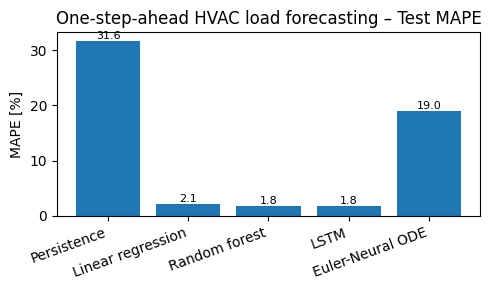

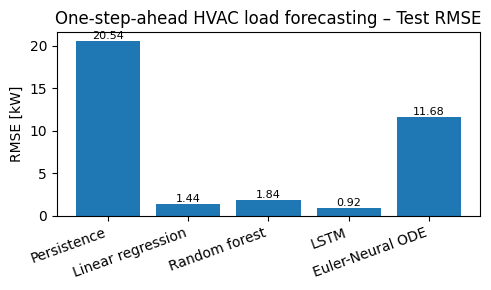

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ==== 1. 如果你已经有这些数，就直接用；否则用我们刚才日志里的值 ====
# 这里先直接硬编码 test / train / val 的结果（单位：MAPE[%], RMSE[kW]）
metrics = {
    "Persistence": {
        "train": {"MAPE": 31.310200, "RMSE": 20.689513},
        "val":   {"MAPE": 32.063442, "RMSE": 20.880519},
        "test":  {"MAPE": 31.627851, "RMSE": 20.544904},
    },
    "Linear regression": {
        "train": {"MAPE": 1.710392, "RMSE": 1.446660},
        "val":   {"MAPE": 1.913671, "RMSE": 1.363919},
        "test":  {"MAPE": 2.099342, "RMSE": 1.442647},
    },
    "Random forest": {
        "train": {"MAPE": 0.786225, "RMSE": 0.541769},
        "val":   {"MAPE": 1.274161, "RMSE": 0.994341},
        "test":  {"MAPE": 1.781286, "RMSE": 1.842159},
    },
    "LSTM": {
        "train": {"MAPE": 1.493, "RMSE": 0.781},
        "val":   {"MAPE": 1.762, "RMSE": 0.854},
        "test":  {"MAPE": 1.761, "RMSE": 0.923},
    },
    "Euler-Neural ODE": {
        "train": {"MAPE": 18.871, "RMSE": 11.718},
        "val":   {"MAPE": 19.139, "RMSE": 11.819},
        "test":  {"MAPE": 18.964, "RMSE": 11.677},
    },
}

# 转成 DataFrame：行=模型，列=split
rows_mape = []
rows_rmse = []
for model, splits in metrics.items():
    for split, vals in splits.items():
        rows_mape.append({"model": model, "split": split, "MAPE": vals["MAPE"]})
        rows_rmse.append({"model": model, "split": split, "RMSE": vals["RMSE"]})

df_mape = pd.DataFrame(rows_mape)
df_rmse = pd.DataFrame(rows_rmse)

# 只画 test split（报告里最关键）
mape_test = df_mape[df_mape["split"] == "test"].set_index("model")["MAPE"]
rmse_test = df_rmse[df_rmse["split"] == "test"].set_index("model")["RMSE"]

# 保证顺序
order = ["Persistence", "Linear regression", "Random forest", "LSTM", "Euler-Neural ODE"]
mape_test = mape_test.loc[order]
rmse_test = rmse_test.loc[order]

output_dir = Path(".")
output_dir.mkdir(exist_ok=True)

# ==== Figure 1: Test MAPE bar ====
plt.figure(figsize=(5, 3))
bars = plt.bar(np.arange(len(order)), mape_test.values)
plt.xticks(np.arange(len(order)), order, rotation=20, ha="right")
plt.ylabel("MAPE [%]")
plt.title("One-step-ahead HVAC load forecasting – Test MAPE")

# 在柱顶标数字
for i, b in enumerate(bars):
    height = b.get_height()
    plt.text(
        b.get_x() + b.get_width() / 2,
        height,
        f"{height:.1f}",
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.tight_layout()
plt.savefig(output_dir / "fig_mape_bar.png", dpi=300, bbox_inches="tight")
plt.savefig(output_dir / "fig_mape_bar.pdf", bbox_inches="tight")
plt.show()

# ==== Figure 2: Test RMSE bar ====
plt.figure(figsize=(5, 3))
bars = plt.bar(np.arange(len(order)), rmse_test.values)
plt.xticks(np.arange(len(order)), order, rotation=20, ha="right")
plt.ylabel("RMSE [kW]")
plt.title("One-step-ahead HVAC load forecasting – Test RMSE")

for i, b in enumerate(bars):
    height = b.get_height()
    plt.text(
        b.get_x() + b.get_width() / 2,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.tight_layout()
plt.savefig(output_dir / "fig_rmse_bar.png", dpi=300, bbox_inches="tight")
plt.savefig(output_dir / "fig_rmse_bar.pdf", bbox_inches="tight")
plt.show()

Using device for inference: cuda


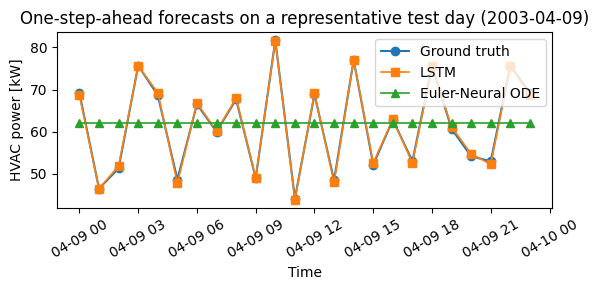

In [29]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# 用和训练时一样的 device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device for inference:", device)

# 把模型搬到对应 device，并切换到 eval 模式
model.to(device).eval()        # LSTM
model_node.to(device).eval()   # Euler-Neural ODE

# ---------- 选一个测试集里的“代表性一天” ----------
# t_test 是 DatetimeIndex，对应每个样本预测的时间戳
test_times = t_test

# 取测试集中间位置的一天，基本比较典型
mid_idx = len(test_times) // 2
day_start = test_times[mid_idx].normalize()             # 00:00
day_end   = day_start + pd.Timedelta(days=1)            # 次日 00:00

mask = (test_times >= day_start) & (test_times < day_end)
idxs = np.where(mask)[0]

# 如果意外少于 24 个点，就退而求其次：取测试集前 24 个样本
if len(idxs) < 24:
    print("[warn] 选中的那天不足 24 个点，用 test split 前 24 个样本代替。")
    idxs = np.arange(24)

X_ex = X_test[idxs]      # (T, 24, 6)
y_ex = y_test[idxs]      # (T,)
t_ex = test_times[idxs]  # DatetimeIndex

# ---------- 计算 LSTM 和 Euler-NODE 在这一天上的预测 ----------
X_ex_t = torch.from_numpy(X_ex).float().to(device)

with torch.no_grad():
    y_lstm_ex  = model(X_ex_t).cpu().numpy().squeeze()
    y_node_ex  = model_node(X_ex_t).cpu().numpy().squeeze()

# ---------- 画图 ----------
plt.figure(figsize=(6, 3))
plt.plot(t_ex, y_ex,      label="Ground truth",      marker="o", linewidth=1.5)
plt.plot(t_ex, y_lstm_ex, label="LSTM",             marker="s", linewidth=1.2)
plt.plot(t_ex, y_node_ex, label="Euler-Neural ODE", marker="^", linewidth=1.2)

plt.xlabel("Time")
plt.ylabel("HVAC power [kW]")
plt.title(f"One-step-ahead forecasts on a representative test day ({day_start.date()})")
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()

plt.savefig("fig_example_day_timeseries.png", dpi=300, bbox_inches="tight")
plt.savefig("fig_example_day_timeseries.pdf", bbox_inches="tight")
plt.show()